In [141]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import scipy
from sklearn.preprocessing import StandardScaler
from scipy import signal
from scipy import fft
from scipy.fft import fft, ifft, fftfreq
import matplotlib
import matplotlib. pyplot as plt
from sklearn.preprocessing import RobustScaler


In [142]:
df = pd.read_csv('signal.csv') # change file name acc. to your file as "('/content/"Your_file_name.csv")"
df

,2024-11-03 23:05:50.643648,484
0,2024-11-03 23:05:50.643818,473
1,2024-11-03 23:05:50.645314,477
2,2024-11-03 23:05:50.645376,486
3,2024-11-03 23:05:50.649459,489
4,2024-11-03 23:05:50.649542,501
...,...,...
915625,2024-11-03 23:42:45.814007,537
915626,2024-11-03 23:42:45.814245,17
915627,2024-11-03 23:42:45.819312,5
915628,2024-11-03 23:42:45.819439,232


# **Change the Labeling according to your data here **

In [143]:
df.loc[:457815,'label'] = 0 # here we have half data point for relax and other half of attentive state
df.loc[475816:,'label'] = 1

In [144]:
df.isnull().sum()

2024-11-03 23:05:50.643648        0
484                               0
label                         18000
dtype: int64

In [145]:
df.drop(df.index[150000:310001], inplace=True)
df.reset_index(drop=True, inplace=True)
df.drop(df.index[600000:750000], inplace=True)
#df = df.loc[600000:]
df.reset_index(drop=True, inplace=True)


In [146]:

df.drop(columns=df.columns[0], axis=1, inplace=True)
df

,484,label
0,473,0.0
1,477,0.0
2,486,0.0
3,489,0.0
4,501,0.0
...,...,...
605624,537,1.0
605625,17,1.0
605626,5,1.0
605627,232,1.0


In [147]:
df.columns = ['raw_eeg', 'label']
df

,raw_eeg,label
0,473,0.0
1,477,0.0
2,486,0.0
3,489,0.0
4,501,0.0
...,...,...
605624,537,1.0
605625,17,1.0
605626,5,1.0
605627,232,1.0


In [148]:
data = df['raw_eeg']
labels_old = df['label']



sampling_rate = 512

notch_freq = 50.0  # for the notch filter
lowcut, highcut = 0.5, 30.0  # for the bandpass filter

#  notch filter
nyquist = (0.5 * sampling_rate)
notch_freq_normalized = notch_freq / nyquist
b_notch, a_notch = signal.iirnotch(notch_freq_normalized, Q=0.05, fs=sampling_rate)

#  bandpass filter
lowcut_normalized = lowcut / nyquist
highcut_normalized = highcut / nyquist
b_bandpass, a_bandpass = signal.butter(4, [lowcut_normalized, highcut_normalized], btype='band')

features = []
labels = []
additional_features_list = []

def calculate_psd_features(segment, sampling_rate):
    f, psd_values = scipy.signal.welch(segment, fs=sampling_rate, nperseg=len(segment))

    alpha_indices = np.where((f >= 8) & (f <= 13))
    beta_indices = np.where((f >= 14) & (f <= 30))
    theta_indices = np.where((f >= 4) & (f <= 7))
    delta_indices = np.where((f >= 0.5) & (f <= 3))

    energy_alpha = np.sum(psd_values[alpha_indices])
    energy_beta = np.sum(psd_values[beta_indices])
    energy_theta = np.sum(psd_values[theta_indices])
    energy_delta = np.sum(psd_values[delta_indices])

    # Calculate the alpha-beta ratio feature
    alpha_beta_ratio = energy_alpha / energy_beta

    return {
        'E_alpha': energy_alpha,
        'E_beta': energy_beta,
        'E_theta': energy_theta,
        'E_delta': energy_delta,
        'alpha_beta_ratio': alpha_beta_ratio
    }

def calculate_additional_features(segment, sampling_rate):
    f, psd = scipy.signal.welch(segment, fs=sampling_rate, nperseg=len(segment))

    # Peak frequency
    peak_frequency = f[np.argmax(psd)]

    # Spectral centroid
    spectral_centroid = np.sum(f * psd) / np.sum(psd)

    # Spectral slope
    log_f = np.log(f[1:])
    log_psd = np.log(psd[1:])
    spectral_slope = np.polyfit(log_f, log_psd, 1)[0]

    return {
        'peak_frequency': peak_frequency,
        'spectral_centroid': spectral_centroid,
        'spectral_slope': spectral_slope
    }


for i in range(0, len(data) - 512, 256):
    segment = data.loc[i:i+512]
    segment = pd.to_numeric(segment, errors='coerce')

    #  notch filter
    segment = signal.filtfilt(b_notch, a_notch, segment)

    #  bandpass filter
    segment = signal.filtfilt(b_bandpass, a_bandpass, segment)


    segment_features = calculate_psd_features(segment,512)
    additional_features = calculate_additional_features(segment, 512)

    segment_features = {**segment_features, **additional_features}

    features.append(segment_features)
    labels.append(labels_old[i])

X = np.array(features)
y = np.array(labels)

In [149]:
#features
segment_features

{'E_alpha': 0.6863350898121152,
 'E_beta': 1.22651826461008,
 'E_theta': 2.2275615131643223,
 'E_delta': 2153.130153340282,
 'alpha_beta_ratio': 0.5595799994305887,
 'peak_frequency': 0.9980506822612085,
 'spectral_centroid': 1.1752094777767355,
 'spectral_slope': -8.795731721072583}

In [150]:
columns = ['E_alpha', 'E_beta', 'E_theta', 'E_delta', 'alpha_beta_ratio','peak_frequency','spectral_centroid','spectral_slope']

# Create a DataFrame
df = pd.DataFrame(features, columns=columns)

df['label'] = y


In [151]:
df.describe()

,E_alpha,E_beta,E_theta,E_delta,alpha_beta_ratio,peak_frequency,spectral_centroid,spectral_slope,label
count,2364.000000,2364.000000,2364.000000,2364.000000,2364.000000,2364.000000,2364.000000,2364.000000,2294.000000
mean,7.341937,13.287548,10.043912,657.968401,0.699335,1.383930,2.992057,-9.295626,0.492589
std,35.974034,94.286404,52.905164,778.218221,0.984193,2.239028,3.243684,0.826143,0.500054
min,0.000956,0.003623,0.000588,0.004902,0.016496,0.000000,0.725233,-13.386204,0.000000
25%,1.132241,2.673519,0.938916,53.084116,0.247291,0.998051,0.927155,-9.815331,0.000000
50%,1.992112,4.527768,1.818767,355.206359,0.451320,0.998051,1.549876,-9.275085,0.000000
75%,4.050026,8.592776,3.943195,1064.736971,0.835236,0.998051,3.491094,-8.588537,1.000000
max,1038.766500,4235.553677,1247.134814,6177.734606,24.235739,28.943470,21.221874,-7.681205,1.000000


In [152]:
#df.to_csv('ready.csv')

In [153]:
scaler = StandardScaler()
#scaler = RobustScaler()
X_scaled = scaler.fit_transform(df.drop('label', axis=1))
df_scaled = pd.DataFrame(X_scaled, columns=columns)

# Add labels to the DataFrame
df_scaled['label'] = df['label']

In [154]:
#df_scaled
X_scaled

array([[ 1.44556941,  0.5821209 ,  0.40062428, ..., -0.17237875,
         1.45386395, -1.44013829],
       [-0.03682234, -0.07906751, -0.13043034, ..., -0.17237875,
         1.6095018 , -0.63290103],
       [-0.14679905, -0.07601765, -0.10453648, ..., -0.17237875,
         0.0188444 , -0.65602143],
       ...,
       [-0.1904914 , -0.12793841, -0.16243568, ..., -0.17237875,
        -0.62766432,  1.75358628],
       [-0.19731011, -0.12500877, -0.17706783, ..., -0.17237875,
        -0.4651546 ,  1.34571984],
       [-0.18505041, -0.12794614, -0.14777394, ..., -0.17237875,
        -0.56023705,  0.60522184]])

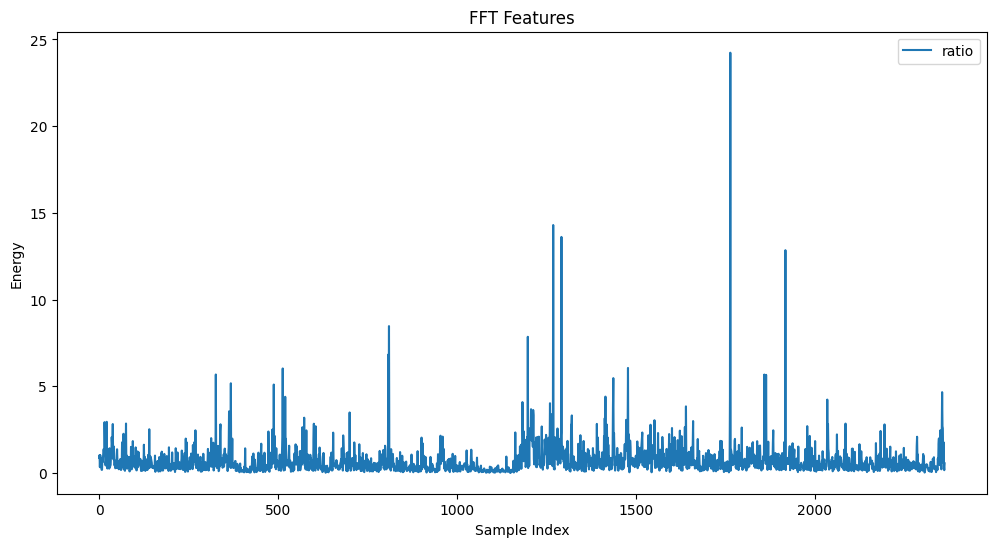

In [155]:
import matplotlib.pyplot as plt



# Plot FFT features
plt.figure(figsize=(12, 6))
#plt.plot(df.index, df['E_alpha'], label='Alpha Energy')
#plt.plot(df.index, df['E_beta'], label='Beta Energy')
###plt.plot(df.index, df['E_theta'], label='theta Energy')
#plt.plot(df.index, df['E_delta'], label='delta Energy')

plt.plot(df.index, df['alpha_beta_ratio'], label='ratio')

plt.xlabel('Sample Index')
plt.ylabel('Energy')
plt.title('FFT Features')
plt.legend()
plt.show()




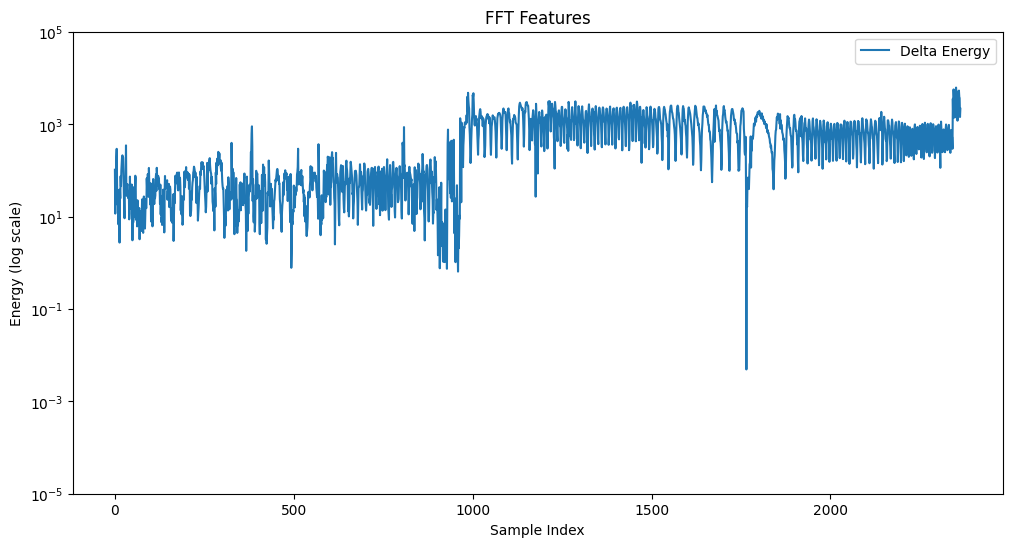

In [156]:
import matplotlib.pyplot as plt

# Plot FFT features
plt.figure(figsize=(12, 6))
#plt.plot(df.index, df['E_alpha'], label='Alpha Energy')
#plt.plot(df.index, df['E_beta'], label='Beta Energy')
#plt.plot(df.index, df['E_theta'], label='Theta Energy')
plt.plot(df.index, df['E_delta'], label='Delta Energy')
#plt.plot(df.index, df['alpha_beta_ratio'], label='Alpha/Beta Ratio')

plt.yscale('log')

threshold = 1e5
plt.ylim([1e-5, threshold])

plt.xlabel('Sample Index')
plt.ylabel('Energy (log scale)')
plt.title('FFT Features')
plt.legend()
plt.show()


In [157]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np

# Check initial class distribution
print("Initial class distribution:")
print(df_scaled['label'].value_counts())

# Perform a stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df_scaled.drop('label', axis=1), 
    df_scaled['label'], 
    test_size=0.2, 
    random_state=42, 
    stratify=df_scaled['label']
)

# Check the class distribution in y_train and y_test
print("Class distribution in y_train:", np.unique(y_train, return_counts=True))
print("Class distribution in y_test:", np.unique(y_test, return_counts=True))

# Verify that both classes are present in y_train
if len(np.unique(y_train)) > 1:
    # Initialize and train the classifier only if both classes are present
    clf = SVC(probability=True, random_state=42)
    clf.fit(X_train, y_train)

    # Make predictions and calculate accuracy
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Classification Accuracy: {accuracy}")
else:
    print("Error: y_train contains only one class after splitting. Consider adjusting the dataset or using resampling.")


Initial class distribution:
label
0.0    1164
1.0    1130
Name: count, dtype: int64


ValueError: Input y contains NaN.

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

X = df_scaled.drop('label', axis=1)
y = df_scaled['label']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}

svc = SVC(probability=True)

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

model = grid_search.best_estimator_
y_pred = model.predict(X_test)
test_accuracy = model.score(X_test, y_test)
print("Test set accuracy: {:.2f}".format(test_accuracy))


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   2.7s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   2.8s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   3.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   3.0s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   2.9s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   3.3s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   3.3s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   3.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   1.5s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.9s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   1.8s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   1.9s
[CV] END ...................

In [ ]:
X_test

,E_alpha,E_beta,E_theta,E_delta,alpha_beta_ratio,peak_frequency,spectral_centroid,spectral_slope
2313,-0.063068,-0.071143,-0.085105,-0.152272,-0.223569,-0.397339,1.228444,-0.198129
2089,-0.076364,-0.061994,-0.081420,0.022084,-0.858890,-0.397339,-1.175050,1.303166
761,-0.072571,-0.086964,-0.090873,-0.146034,-0.300603,-0.397339,-0.333358,-0.042650
829,-0.075523,-0.086949,-0.092001,-0.152554,-0.639105,-0.397339,0.510616,0.223050
1961,-0.060570,-0.091612,-0.089324,-0.101356,2.581621,-0.397339,-1.071974,0.153408
...,...,...,...,...,...,...,...,...
49,-0.073503,-0.094311,-0.093066,-0.150300,0.675623,-0.397339,-0.450070,-0.406904
1505,-0.066707,-0.065773,-0.071275,-0.126482,-0.479769,-0.397339,0.037995,-0.412826
1846,-0.046848,0.023803,-0.050580,-0.007014,-0.596908,-0.397339,-0.135435,-1.445897
48,-0.074203,-0.090401,-0.093561,-0.146091,-0.288586,-0.397339,-0.291921,0.826461


In [ ]:
import pickle

model_filename = 'model.pkl'

with open(model_filename, 'wb') as file:
    pickle.dump(model, file)


In [ ]:
import pickle

scaler_filename = 'scaler.pkl'

with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)


In [ ]:
probabilities = model.predict_proba(X_test)[:,1]
print(f"Class Probabilities: {probabilities}")

Class Probabilities: [0.77826761 0.77879426 0.7788289  0.77821384 0.78715395 0.77839177
 0.77878634 0.77860273 0.77859824 0.77851055 0.77723436 0.77836104
 0.78057523 0.77851003 0.77923264 0.77835321 0.77852225 0.77904837
 0.77855942 0.77978839 0.77854821 0.78015443 0.77842977 0.77863445
 0.77843379 0.77766512 0.76370249 0.7782453  0.77857039 0.77852576
 0.77825475 0.77841151 0.77862095 0.77829292 0.77855212 0.76793817
 0.77832539 0.78012021 0.77836639 0.77882878 0.77817578 0.77845437
 0.78070133 0.77856283 0.77862365 0.77895767 0.77806775 0.77820777
 0.77842092 0.77823454 0.77827773 0.77808813 0.77852795 0.77846717
 0.77878754 0.77851006 0.76721563 0.77793331 0.77835288 0.77818332
 0.77854974 0.77852941 0.77845589 0.77917212 0.77812695 0.77808928
 0.78078786 0.77857767 0.77861849 0.77853222 0.77858736 0.7781819
 0.77866057 0.77857328 0.77872752 0.7788112  0.77863236 0.77835285
 0.77851925 0.77846255 0.77821622 0.77884284 0.77977221 0.77912159
 0.77834939 0.77902708 0.77835866 0.781056

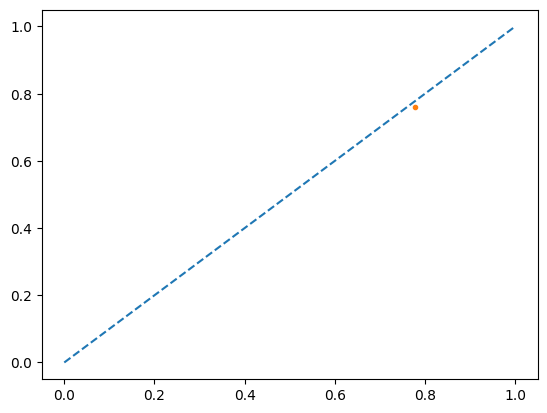

In [ ]:
from sklearn.calibration import calibration_curve
fop, mpv = calibration_curve(y_test, probabilities, n_bins=10)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(mpv, fop, marker='.')
plt.show()

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

calibrator = CalibratedClassifierCV(model, cv=3)
calibrator.fit(X_train,y_train)
yhat = calibrator.predict(X_test)

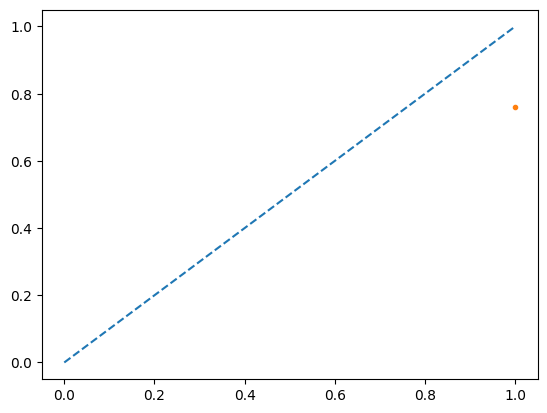

In [ ]:
fop, mpv = calibration_curve(y_test, yhat, n_bins=10)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(mpv, fop, marker='.')
plt.show()

In [ ]:
accuracy = accuracy_score(y_test, yhat)
print(f"Classification Accuracy: {accuracy}")

Classification Accuracy: 0.7591522157996147


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

y_true = df_scaled['label']
y_pred = model.predict(X_scaled)

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Precision
precision = precision_score(y_true, y_pred)
print(f'Precision: {precision:.4f}')

# Recall
recall = recall_score(y_true, y_pred)
print(f'Recall: {recall:.4f}')

# F1 Score
f1 = f1_score(y_true, y_pred)
print(f'F1 Score: {f1:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Classification Report
class_report = classification_report(y_true, y_pred)
print('Classification Report:')
print(class_report)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Accuracy: 0.7739
Precision: 0.7739
Recall: 1.0000
F1 Score: 0.8726
Confusion Matrix:
[[   0  586]
 [   0 2006]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       586
         1.0       0.77      1.00      0.87      2006

    accuracy                           0.77      2592
   macro avg       0.39      0.50      0.44      2592
weighted avg       0.60      0.77      0.68      2592



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  